<a href="https://colab.research.google.com/github/bharathi-srini/Bayesian_Inference_Recommender_Systems/blob/master/light_gbm_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt

In [84]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/BNN_RecSys/'

df_use = pd.read_csv(root_path+"engineered_data_100.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_orders, test_orders, y_tr, y_te = train_test_split(df_use, df_use['reordered'], stratify=df_use['reordered'], random_state = 100, test_size=0.25)

In [86]:
CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order","reordered_total","product_id_orders","user_distinct_products","user_period",\
                     "user_orders","average_cart_position"]
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_orders[CONTINUOUS_COLUMNS] = sc.fit_transform(train_orders[CONTINUOUS_COLUMNS].values)
test_orders[CONTINUOUS_COLUMNS] = sc.fit_transform(test_orders[CONTINUOUS_COLUMNS].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [87]:
f_to_use = CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS


print('formating for lgb')
d_train = lgb.Dataset(train_orders[f_to_use],categorical_feature=['aisle_id', 'department_id', "order_dow", "order_hour_of_day"], label =y_tr )  # , 'order_hour_of_day', 'dow'

formating for lgb


In [0]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

In [89]:
print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)

light GBM train :-)


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [99]:
#df_test = lgb.Dataset(test_orders[f_to_use],categorical_feature=['aisle_id', 'department_id'])
TRESHOLD = 0.6
print('light GBM predict')
y_pred_prob = bst.predict(test_orders[f_to_use])
y_pred = []

for i in range(0,len(y_pred_prob)):
    if (y_pred_prob[i] >= TRESHOLD):
        y_pred.append(1)
    else:
        y_pred.append(0)
 

test_orders['pred'] = y_pred_prob

light GBM predict


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [100]:
  # guess, should be tuned with crossval on a subset of train data

#Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_te)
accuracy

0.981924478116386

In [101]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, y_pred)
cm

array([[ 84031,   6904],
       [  3942, 505161]])

Confusion matrix, without normalization
[[ 84031   6904]
 [  3942 505161]]
Normalized confusion matrix
[[0.92 0.08]
 [0.01 0.99]]


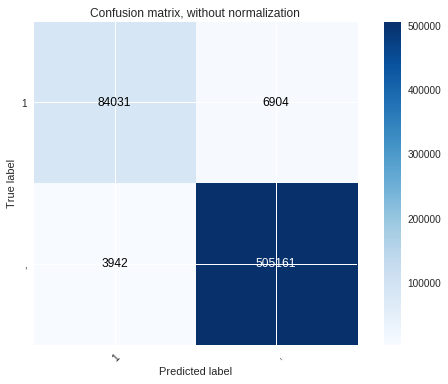

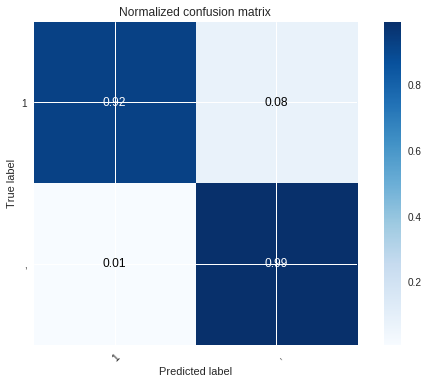

In [93]:
def plot_confusion_matrix(y_true, y_pred, classes=2,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_te, y_pred, classes='1,0',
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_te, y_pred, classes='1,0', normalize=True,
                      title='Normalized confusion matrix')

plt.savefig(root_path+'lightgbm_cm.png')
plt.show()

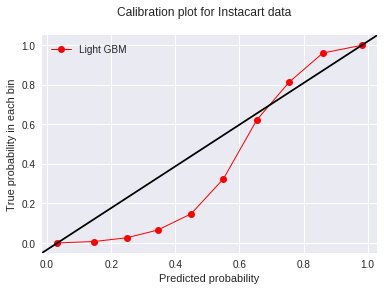

In [103]:
from sklearn.calibration import calibration_curve
logreg_y, logreg_x = calibration_curve(y_te, y_pred_prob, n_bins=10)

np.save(root_path+'y_LGBM.csv',logreg_y)
np.save(root_path+'x_LGBM.csv',logreg_x) 

#logreg_y_bnn, logreg_x_bnn = calibration_curve(y_test, predictive_mean_BNN, n_bins=10)
#logreg_y_20, logreg_x_20 = calibration_curve(y_test, percentile_probs_BNN, n_bins=10)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='Light GBM', color='red')
#plt.plot(logreg_x_bnn,logreg_y_bnn, marker='o', linewidth=1, label='MC Dropout')
#plt.plot(logreg_x_20,logreg_y_20, marker='o', linewidth=1, label='MC Dropout (20%)',color='green')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

fig.suptitle('Calibration plot for Instacart data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()

#plt.savefig(root_path+"calibration_plot.png")
plt.show()

In [0]:
# Out of distribution samples
out_user = pd.read_csv(root_path + 'engineered_data_users_out.csv')
out_prod = pd.read_csv(root_path + 'engineered_data_out_prd.csv')
out_both = pd.read_csv(root_path + 'engineered_data_out_both.csv')

In [0]:
#Out of distribution prediction
y_pred_new_users = bst.predict(out_user[f_to_use])
y_pred_new_prd = bst.predict(out_prod[f_to_use])
y_pred_new_both = bst.predict(out_both[f_to_use])

In [109]:
from sklearn.metrics import f1_score, log_loss, brier_score_loss

y_true = out_user['reordered']
print('test results - out of sample users')
print('Accuracy :', accuracy_score(y_true, np.round(y_pred_new_users)))
print('Log Loss :', log_loss(y_true, y_pred_new_users))
print("F1 Score:",f1_score(y_true, np.round(y_pred_new_users), average='weighted') )
print("Brier: ", brier_score_loss(y_true, y_pred_new_users))

y_true = out_prod['reordered']
print('test results - out of sample prods')
print('Accuracy :', accuracy_score(y_true, np.round(y_pred_new_prd)))
print('Log Loss :', log_loss(y_true, y_pred_new_prd))
print("F1 Score:",f1_score(y_true, np.round(y_pred_new_prd), average='weighted') )
print("Brier: ", brier_score_loss(y_true, y_pred_new_prd))

y_true = out_both['reordered']
print('test results - out of sample both')
print('Accuracy :', accuracy_score(y_true, np.round(y_pred_new_both)))
print('Log Loss :', log_loss(y_true, y_pred_new_both))
print("F1 Score:",f1_score(y_true, np.round(y_pred_new_both), average='weighted') )
print("Brier: ", brier_score_loss(y_true, y_pred_new_both))

test results - out of sample users
Accuracy : 0.7339700244543644
Log Loss : 1.3689961934565325
F1 Score: 0.6213625255339221
Brier:  0.2611937697838957
test results - out of sample prods


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy : 0.47924371133178406
Log Loss : 2.75644478325865


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score: 0.31052967552491145
Brier:  0.5127483914646901
test results - out of sample both
Accuracy : 0.47588064901955546
Log Loss : 2.698812423141377
F1 Score: 0.30688442491839013
Brier:  0.5144556632460277


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
